# Section 5
Today
<ul>
<li><a href='https://www.tensorflow.org/api_docs/python/tf/image'>tf.image</a></li>
<li><a href='https://www.tensorflow.org/api_docs/python/tf/map_fn'>tf.map_fn</a></li>
<li><a href='https://www.tensorflow.org/api_docs/python/tf/layers/conv2d'>Weight Regularization</a></li>
<li><a href='https://www.tensorflow.org/api_docs/python/tf/losses'>tf.losses</a></li>
<li><a href='https://www.tensorflow.org/api_docs/python/tf/layers/dropout'>Dropout</a></li>
</ul>

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import util
import matplotlib.pyplot as plt

# Load the data we are giving you
def load(filename, W=64, H=64):
    data = np.fromfile(filename, dtype=np.uint8).reshape((-1, W*H*3+1))
    images, labels = data[:, :-1].reshape((-1,H,W,3)), data[:, -1]
    return images, labels

image_data, label_data = load('tux_train.dat')

print('Input shape: ' + str(image_data.shape))
print('Labels shape: ' + str(label_data.shape))

I = tf.placeholder(tf.float32, (64, 64, 3))

sess = tf.Session()

Input shape: (12257, 64, 64, 3)
Labels shape: (12257,)


## Data Augmentation

(64, 64, 3)


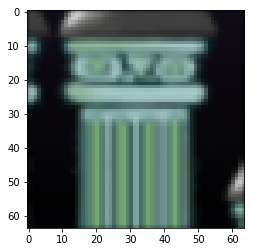

In [2]:
% matplotlib inline

# Original Image
image = image_data[10]
print(image.shape)
plt.imshow(image)

## <a href='https://www.tensorflow.org/api_docs/python/tf/image/random_brightness'>Random Brightness</a>

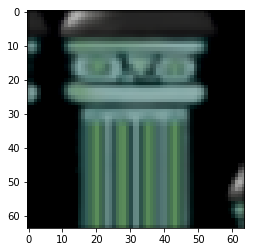

In [3]:
rb = sess.run(tf.image.random_brightness(I, 50), {I: image})
rb = rb.clip(min=0, max=255.0)
rb = rb / 255.0
plt.imshow(rb)

## <a href='https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right'>Random Flip Left Right</a>

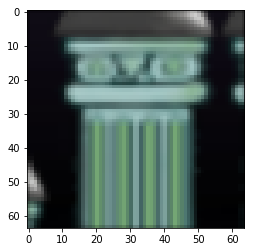

In [4]:
flr = sess.run(tf.image.random_flip_left_right(I), {I: image})
plt.imshow(flr / 255.0)

## <a href='https://www.tensorflow.org/api_docs/python/tf/image/random_saturation'>Random Saturation</a>

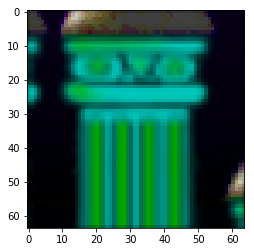

In [5]:
rs = sess.run(tf.image.random_saturation(I, 0.0, 50.0), {I: image})
plt.imshow(rs / 255.0)

## Using <a href='https://www.tensorflow.org/api_docs/python/tf/map_fn'>tf.map_fn</a>

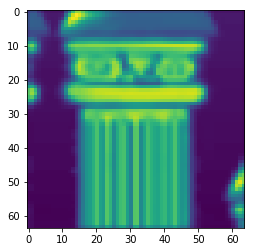

In [6]:
gs = sess.run(tf.image.rgb_to_grayscale(I), {I: image})
#plt.imshow()
#plt.imshow(gs / 255.0)
plt.imshow(np.squeeze(gs, axis=-1))

In [7]:
# How can we apply a transformation to the whole dataset?
inputs = tf.placeholder(tf.float32, (None))

def square(x):
    return x ** 2

squared_values = tf.map_fn(square, inputs)
print('Original: ' + str(np.linspace(0, 9, 10)))
print('Squared:  ' + str(sess.run(squared_values, {inputs: np.linspace(0, 9, 10)})))


Original: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
Squared:  [  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]


In [8]:
# Now let's apply this with an image augmentation
image_batch = tf.placeholder(tf.float32, (None, 64, 64, 3))
def data_augmentation(I):
    # Pick your favorite data augmentation
    I = tf.image.random_saturation(I, 0.0, 10.0)
    return I

aug_images = tf.map_fn(data_augmentation, image_batch)
aug_out = sess.run(aug_images, {image_batch: image_data[0:10]})

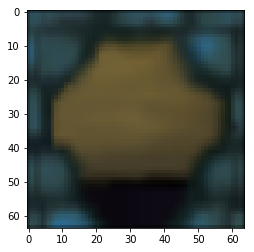

In [9]:
index = 5
plt.imshow(image_data[index])

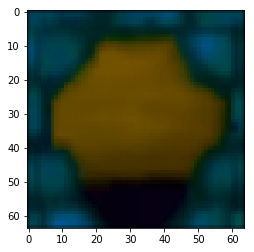

In [10]:
plt.imshow(aug_out[index] / 255.0)

## Weight Regularization

In [11]:
input_images = tf.placeholder(tf.float32, (None, 64, 64, 3))
labels = tf.placeholder(tf.int64, (None), name='labels')

# Before we had this
# h = tf.contrib.layers.conv2d(image_batch, 10, (5,5), stride=2, scope="conv1")

# Now we add regularization
h = tf.contrib.layers.conv2d(image_batch, 10, (5,5), stride=2, scope="conv1", weights_regularizer=tf.nn.l2_loss)

## Losses
<a href='https://www.tensorflow.org/api_docs/python/tf/losses/get_regularization_loss'>tf.losses.get_regularization_loss</a>

In [12]:
# Basic loss like before
h = tf.contrib.layers.conv2d(h, 10, (5,5), stride=2, scope="conv2", weights_regularizer=tf.nn.l2_loss)
h = tf.contrib.layers.conv2d(h, 10, (5,5), stride=2, scope="conv3", weights_regularizer=tf.nn.l2_loss)
h = tf.contrib.layers.flatten(h)
print(h)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=labels))

# Nowe we're adding regularization to our loss to penalize large weights
regularization_loss = tf.losses.get_regularization_loss()

alpha = 1e-8 # We want to keep this penalty small relative to the original loss
total_loss = loss + alpha * regularization_loss
print(total_loss)

opt = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(total_loss)

Tensor("Flatten/Reshape:0", shape=(?, 640), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


## Dropout
<a href='https://www.tensorflow.org/api_docs/python/tf/layers/dropout'>tf.layers.dropout</a><br/><br/>
"Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. The units that are kept are scaled by 1 / (1 - rate), so that their sum is unchanged at training time and inference time."

In [17]:
dropped = tf.layers.dropout(h)
drop_input = tf.placeholder(tf.float32, (10))
dropped2 = tf.layers.dropout(drop_input, training=True)
print(sess.run(dropped2, {drop_input: np.random.rand(10)}))

[ 1.01955438  1.50070918  0.          1.66539526  0.34945896  0.
  0.86733323  1.72688544  1.09127653  0.15132444]
